In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
import scipy.stats as stats

from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [41]:
review = pd.read_csv('Hotel_Reviews.csv', parse_dates = [0], infer_datetime_format = True)

In [42]:
review2 = review['Positive_Review']

review2.sample(10) #Random sample of the dataset (10)

381544     The views from the hotel were absolutely beau...
188208     Excellent bathroom with a good shower Beds an...
403548     bed extra comfy great to have an honesty bar ...
189784                         It was quiet and comfortable
93307      Very pleased with our stay staff couldn t do ...
439809     From my perspective all was a very good Good ...
60990                                               Nothing
449250                       good Breakfast friendly people
64544      Loved everything rhe sights the staff the fac...
357582     Brilliant location for Greenwich s attraction...
Name: Positive_Review, dtype: object

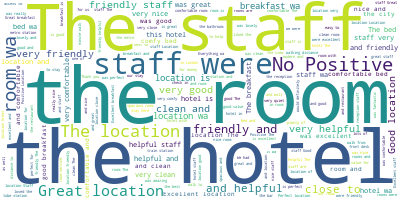

In [43]:
#Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(review['Positive_Review'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='grey')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [44]:
# Defining the helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    This will return a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vec_headlines = count_vectorizer.fit_transform(text_data.values)
    vec_total = np.sum(vec_headlines, axis=0)
    word_indices = np.flip(np.argsort(vec_total)[0,:], 1)
    word_values = np.flip(np.sort(vec_total)[0,:],1)
    
    word_vec = np.zeros((n_top_words, vec_headlines.shape[1]))
    for i in range(n_top_words):
        word_vec[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vec)]

    return (words, word_values[0,:n_top_words].tolist()[0])

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=25,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=review2)

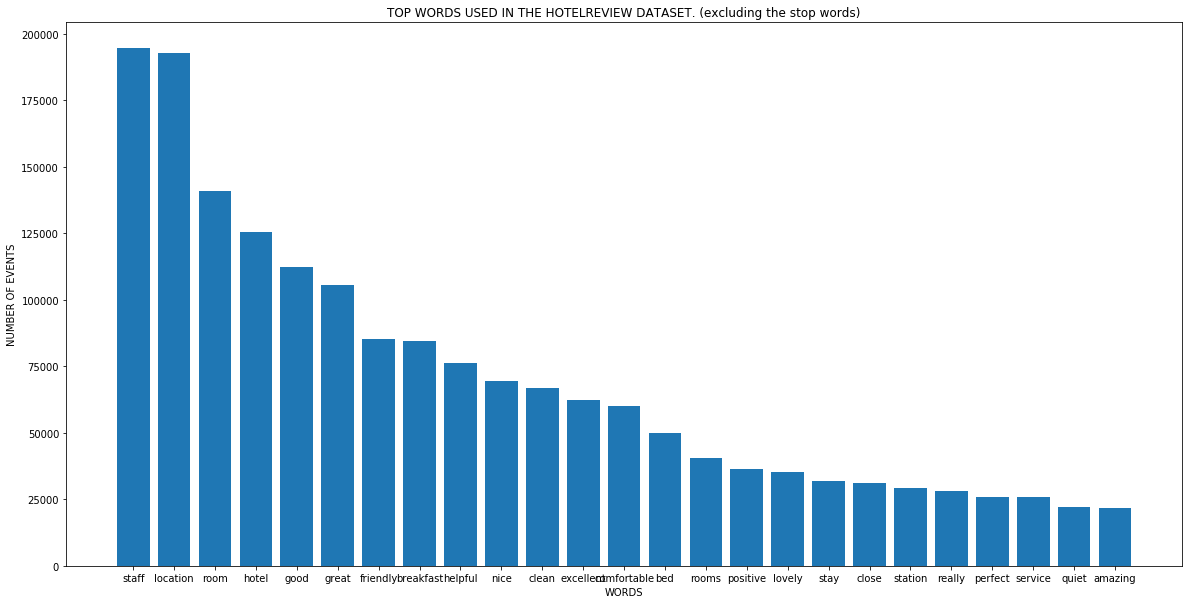

In [45]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='horizontal');
ax.set_title('TOP WORDS USED IN THE HOTELREVIEW DATASET. (excluding the stop words)');
ax.set_xlabel('WORDS');
ax.set_ylabel('NUMBER OF EVENTS');
plt.show()

In [46]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = review2.sample(n=10000, random_state=0).values

print('HEADLINE BEFORE VECTORIZATION: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('HEADLINE AFTER VECTORIZATION: \n{}'.format(small_document_term_matrix[123]))

HEADLINE BEFORE VECTORIZATION:  There is no breakfast at the site The room has Nesoresso machine which I used every day It provides some basic kitchen appliances The room is on the small scale if u choose the basic suite The bathroom is in a good size though for London standard 
HEADLINE AFTER VECTORIZATION: 
  (0, 1230)	1
  (0, 5201)	1
  (0, 465)	1
  (0, 3340)	1
  (0, 679)	2
  (0, 4708)	1
  (0, 6305)	1
  (0, 4035)	1
  (0, 5410)	1
  (0, 5793)	1
  (0, 691)	1
  (0, 3658)	1
  (0, 5657)	1
  (0, 5419)	1
  (0, 3573)	1
  (0, 5451)	1
  (0, 5084)	2
  (0, 1701)	1
  (0, 907)	1
  (0, 2710)	1


In [47]:
num_topics = 5

In [48]:
lsa_model = TruncatedSVD(n_components=num_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [49]:
def get_lsa_topics(lda_model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = small_count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = lsa_model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [50]:
get_lsa_topics(lsa_model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,staff,hotel,good,hotel,good
1,location,room,location,great,breakfast
2,hotel,nice,room,location,staff
3,room,clean,breakfast,rooms,friendly
4,good,comfortable,nice,walk,hotel
5,great,bed,bed,stay,helpful
6,friendly,stay,station,city,nice
7,helpful,really,comfortable,station,clean
8,breakfast,lovely,close,near,rooms
9,nice,view,clean,perfect,excellent


In [51]:
# Defining the helper functions
def get_keys(topic_matrix):
    '''
    This returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    This returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [52]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [53]:
# Defining the helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    This returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(num_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [54]:
top_n_words_lsa = get_top_n_words(15, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  staff location room great hotel friendly helpful breakfast good nice clean excellent comfortable bed positive
Topic 2:  room hotel nice comfortable bed clean view spacious lovely big bathroom small quiet beautiful comfy
Topic 3:  good location room breakfast close bed station clean size near nice value service central london
Topic 4:  hotel location great nice stay perfect rooms lovely station near clean located close just breakfast
Topic 5:  good breakfast staff hotel nice clean rooms bed service food friendly comfortable close bar value


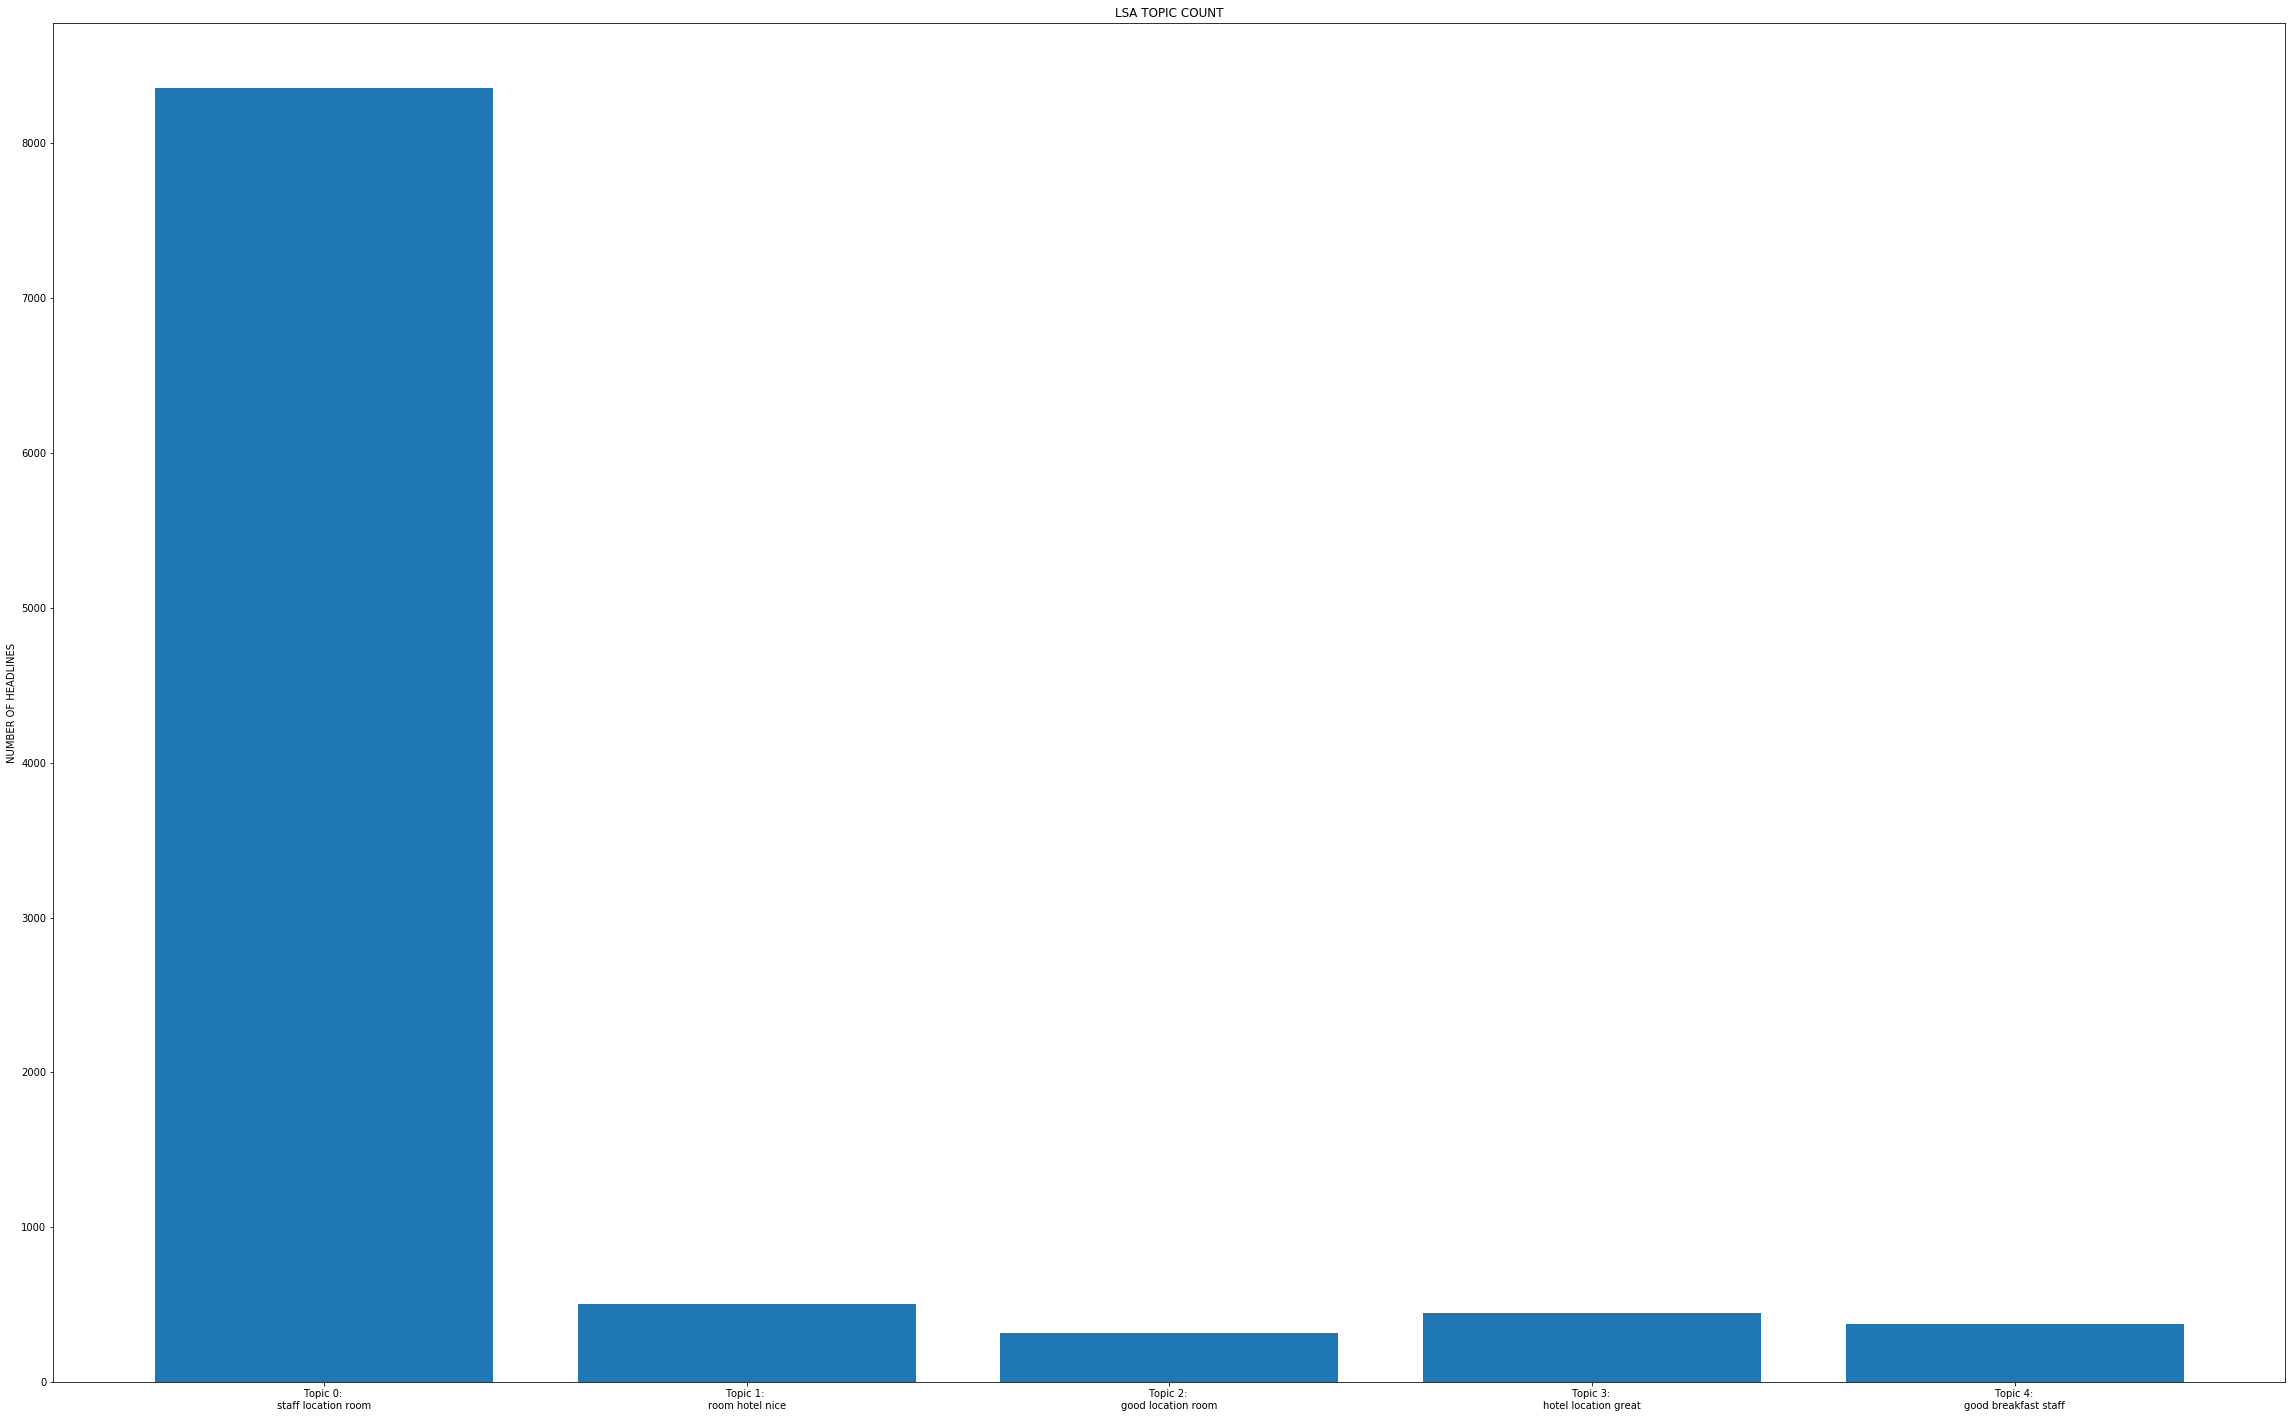

In [55]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(40,25))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('NUMBER OF HEADLINES');
ax.set_title('LSA TOPIC COUNT');
plt.show()

In [56]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.015s...
[t-SNE] Computed neighbors for 10000 samples in 0.559s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.515125
[t-SNE] KL divergence after 2000 iterations: 0.620422


In [57]:
# Defining the helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    This returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(num_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [58]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:num_topics]

In [59]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} LSA TOPICS".format(num_topics), plot_width=900, plot_height=1000)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(num_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

In [60]:
lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [61]:
def get_lda_topics(lda_model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = small_count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = lda_model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [62]:
get_lda_topics(lda_model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,room,easy,room,staff,location
1,quiet,place,bed,location,hotel
2,breakfast,just,positive,friendly,clean
3,hotel,hotel,comfortable,helpful,good
4,walking,right,comfy,great,nice
5,best,street,bathroom,excellent,great
6,distance,pool,beds,breakfast,room
7,good,welcoming,free,good,close
8,really,access,nice,hotel,rooms
9,quite,quiet,lovely,room,station


In [63]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [64]:
top_n_words_lda = get_top_n_words(15, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  room hotel good staff breakfast location nice great really clean friendly bed lovely quiet best
Topic 2:  staff hotel location room great good helpful breakfast friendly stay walk just nice comfortable easy
Topic 3:  positive room bed comfortable staff comfy location good nice great hotel breakfast clean free bathroom
Topic 4:  staff location friendly great helpful room good breakfast excellent hotel nice clean comfortable perfect amazing
Topic 5:  location hotel good staff room clean great nice breakfast close rooms station comfortable friendly excellent


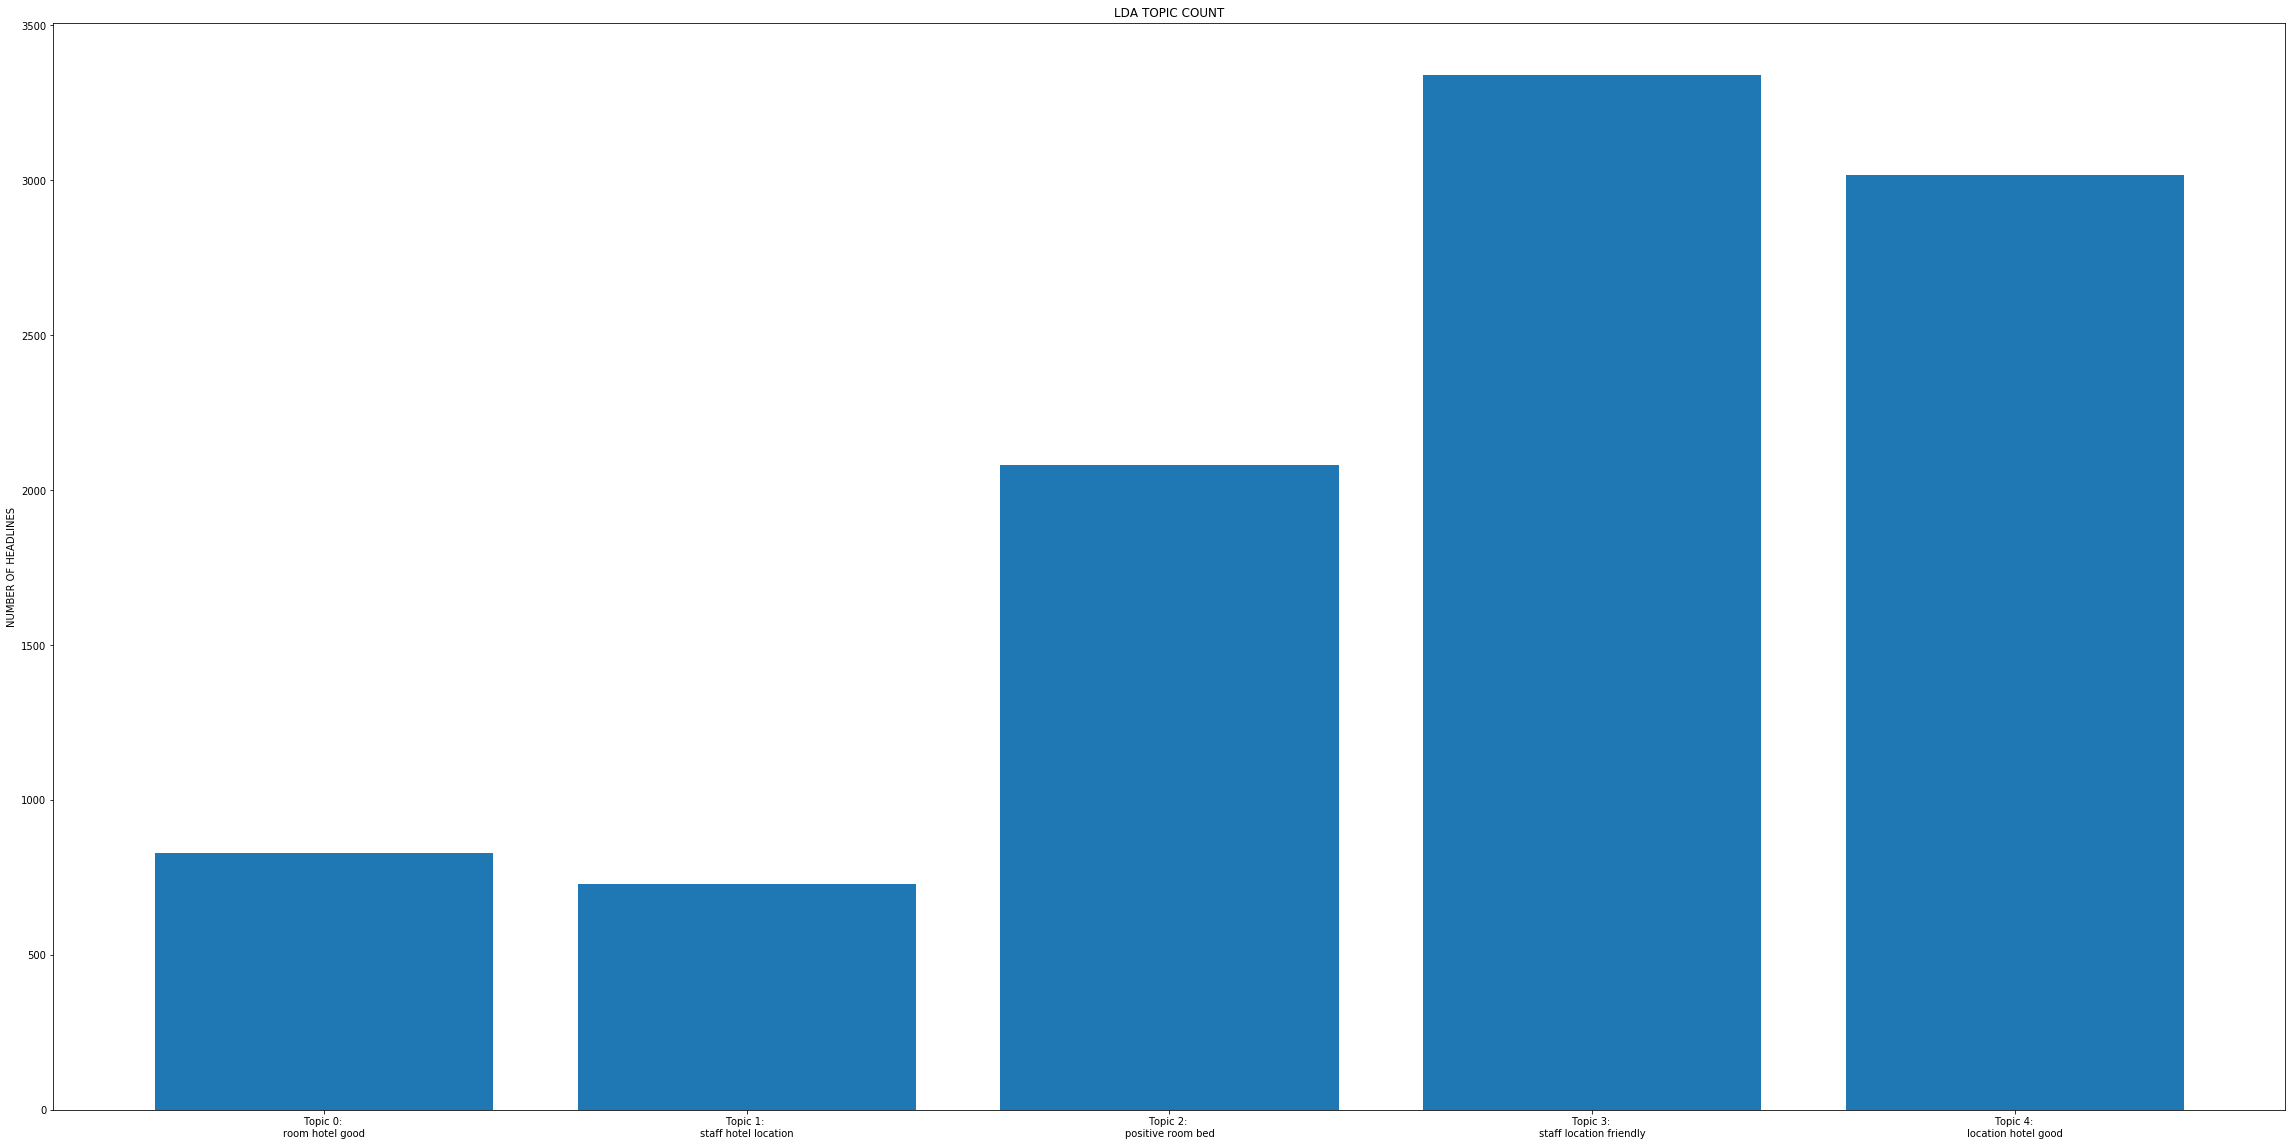

In [65]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(40,20))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA TOPIC COUNT');
ax.set_ylabel('NUMBER OF HEADLINES');

In [66]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 0.535s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.466705
[t-SNE] KL divergence after 2000 iterations: 0.827009


In [67]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} LDA TOPICS".format(num_topics), plot_width=900, plot_height=900)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(num_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [68]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;

In [69]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(small_document_term_matrix);

In [70]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [71]:
#obtain a NMF model.
model = NMF(n_components=num_topics, init='nndsvd');
#fit the model
nnf_topic_matrix = model.fit_transform(xtfidf_norm)
nnf_topic_matrix

array([[1.92184772e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.76425336e-07, 8.09699730e-03, 2.95134424e-03, 1.79996264e-02,
        0.00000000e+00],
       [0.00000000e+00, 2.15489310e-02, 8.54568981e-03, 7.00500207e-02,
        1.23574046e-02],
       ...,
       [3.71354543e-08, 1.29874267e-04, 1.37505803e-03, 2.78897846e-03,
        2.47559488e-03],
       [5.77139479e-07, 0.00000000e+00, 0.00000000e+00, 1.71809932e-01,
        5.29992687e-03],
       [0.00000000e+00, 0.00000000e+00, 5.07276606e-02, 0.00000000e+00,
        1.01403905e-01]])

In [72]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = small_count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [73]:
get_nmf_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,positive,location,staff,good,great
1,energy,excellent,friendly,breakfast,room
2,lots,perfect,helpful,excellent,comfortable
3,place,cleanliness,excellent,room,clean
4,augusto,convenient,nice,nice,bed
5,profesional,fantastic,clean,clean,nice
6,manager,hotel,hotel,hotel,hotel
7,queensway,central,lovely,service,comfy
8,main,comfort,perfect,really,rooms
9,thing,amazing,room,comfortable,breakfast


In [74]:
nnf_keys = get_keys(nnf_topic_matrix)
nnf_categories, nnf_counts = keys_to_counts(nnf_keys)

In [75]:
top_n_words_nnf = get_top_n_words(15, nnf_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_nnf)):
    print("Topic {}: ".format(i+1), top_n_words_nnf[i])

Topic 1:  positive xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx hotel evrything everythinh everythings everyrhing luxery iphone ngen profesional bekv gut main alles
Topic 2:  location excellent hotel perfect room nice station close convenient near clean central fantastic rooms quiet
Topic 3:  staff friendly helpful location hotel room excellent clean nice comfortable breakfast lovely stay rooms perfect
Topic 4:  good breakfast location room staff hotel nice clean excellent comfortable station helpful friendly bed close
Topic 5:  great room hotel location staff comfortable nice clean bed rooms breakfast lovely friendly helpful stay


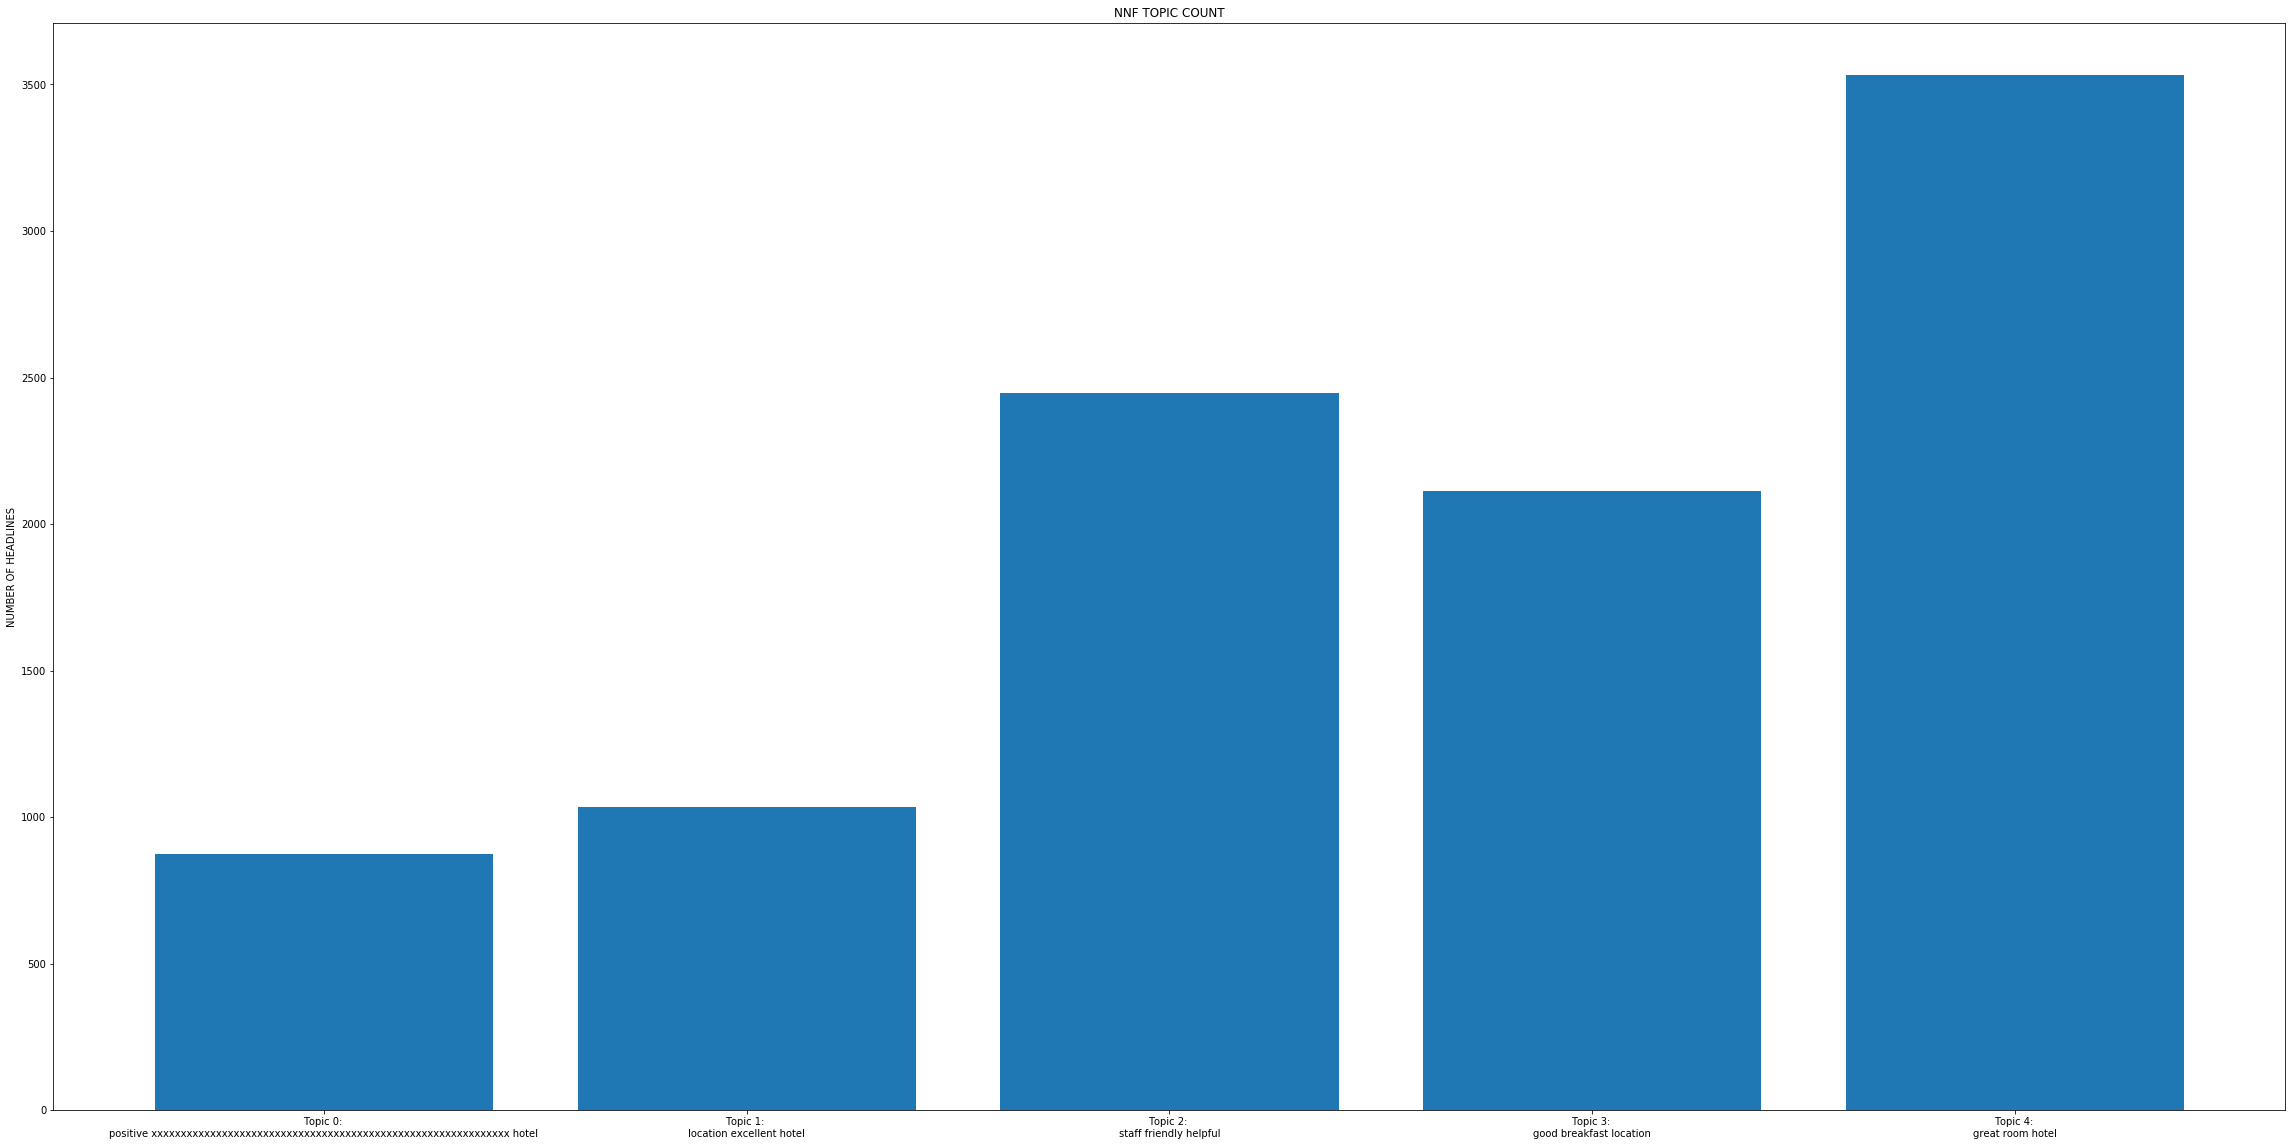

In [76]:
top_3_words = get_top_n_words(3, nnf_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in nnf_categories]

fig, ax = plt.subplots(figsize=(40,20))
ax.bar(nnf_categories, nnf_counts);
ax.set_xticks(nnf_categories);
ax.set_xticklabels(labels);
ax.set_title('NNF TOPIC COUNT');
ax.set_ylabel('NUMBER OF HEADLINES');

In [77]:
tsne_nnf_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_nnf_vectors = tsne_nnf_model.fit_transform(nnf_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.018s...
[t-SNE] Computed neighbors for 10000 samples in 0.531s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.857178
[t-SNE] KL divergence after 2000 iterations: 0.836384


In [78]:
top_3_words_nnf = get_top_n_words(3, nnf_keys, small_document_term_matrix, small_count_vectorizer)
nnf_mean_topic_vectors = get_mean_topic_vectors(nnf_keys, tsne_nnf_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} NNF TOPICS".format(num_topics), plot_width=900, plot_height=900)
plot.scatter(x=tsne_nnf_vectors[:,0], y=tsne_nnf_vectors[:,1], color=colormap[nnf_keys])

for t in range(num_topics):
    label = Label(x=nnf_mean_topic_vectors[t][0], y=nnf_mean_topic_vectors[t][1], 
                  text=top_3_words_nnf[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)